# Imports and MPNN FP function

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem import MolFromSmiles, MolToSmiles, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import DataStructs

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
%matplotlib inline

In [2]:
import subprocess
import argparse
import logging 

import dgl
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from dgllife.model.model_zoo import MPNNPredictor
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_bigraph
from rdkit import Chem
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from torch.nn import MSELoss
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

def bash_command(cmd):
    p = subprocess.Popen(cmd, shell=True, executable='/bin/bash')
    p.communicate()

class dfloader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, df, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param: csv_path (string): path to .csv containing molecular data
        :param: inds (array of ints): train/test indices to select subset of data
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        self.df = df
        self.df.reset_index(drop=True,inplace=True)
        self.dataset_len = len(self.df)

        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        df_batch = self.df.iloc[self.i:self.i+self.batch_size]
        self.i += self.batch_size
        #return batch
        return df_batch['SMILES'].values
        # return df_batch['smiles'].values

    def __len__(self):
        return self.n_batches

model_name='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

def gen_fps(df, load_name=model_name, enumerate_tauts=False):

    data_loader = dfloader(df, batch_size=1024, shuffle=False)
    if enumerate_tauts:
        data_loader = dfloader(df, batch_size=1, shuffle=False) # 1 by 1 to clarify tautomers

    atom_featurizer = CanonicalAtomFeaturizer()
    bond_featurizer = CanonicalBondFeaturizer()

    e_feats = bond_featurizer.feat_size('e')
    n_feats = atom_featurizer.feat_size('h')
    # print('Number of features: ', n_feats)


    # mpnn_net = MPNNPredictor(node_in_feats=n_feats,
    #                          edge_in_feats=e_feats
    #                          )

    mpnn_net = MPNNPredictor(node_in_feats=n_feats,
                 edge_in_feats=e_feats,
                 node_out_feats=32,
                 edge_hidden_feats=32,
                 num_step_message_passing=4,
                 num_step_set2set=2,
                 num_layer_set2set=3) 
    
    checkpoint = torch.load(load_name, map_location=device)
    mpnn_net.load_state_dict(checkpoint['mpnn_state_dict'])
        
    # print('Number of parameters: {}'.format(sum(p.numel() for p in mpnn_net.parameters() if p.requires_grad)))     
    mpnn_net = mpnn_net.to(device)

    mpnn_net.eval()

    all_feats = []
    enumerator = rdMolStandardize.TautomerEnumerator()
    for i, smiles in enumerate(data_loader):
        if enumerate_tauts:
            smiles = [Chem.MolToSmiles(x) for x in enumerator.Enumerate(MolFromSmiles(smiles[0]))]

        graphs = [mol_to_bigraph(Chem.MolFromSmiles(smi), node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer) for smi in smiles] # generate and batch graphs
        bg = dgl.batch(graphs).to(device)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)

        atom_feats = bg.ndata.pop('h').to(device)
        bond_feats = bg.edata.pop('e').to(device)
        atom_feats, bond_feats = atom_feats.to(device), bond_feats.to(device)

        atom_feats = mpnn_net.gnn(bg, atom_feats, bond_feats)
        graph_feats = mpnn_net.readout(bg, atom_feats).cpu().detach().numpy()
        if enumerate_tauts:
            graph_feats = np.mean(graph_feats, axis=0)
        all_feats.append(graph_feats)
        

    all_feats = np.vstack(all_feats)
    print('Shape of MPNN graph features: {}'.format(all_feats.shape))
    return all_feats

Using backend: pytorch


use CPU


# Data processing and feature generation

In [3]:
def generate_fingerprints(smile):
    mol = MolFromSmiles(smile)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024)
    # fp = AllChem.GetMorganFingerprint(mol, radius=3)
    return fp

def fp_to_numpy(fp):
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    # print(array)
    return array

def canon_tautomers(smiles_list):
    enumerator = rdMolStandardize.TautomerEnumerator()

    smiles_list = [ MolToSmiles(enumerator.Canonicalize(MolFromSmiles(smi))) for smi in tqdm(smiles_list) ]

    return smiles_list

def read_df(path, canon=True):
    df = pd.read_csv(path)

    if canon:
        df['SMILES'] = canon_tautomers(df['SMILES']) # canonicalize tautomers!

    df.loc[df['IC50'].astype(str).str.contains('>'), 'IC50'] = 100.0
    df.loc[df['IC50'].isnull(), 'IC50'] = 100.0
    # print(df_train['IC50'])
    # print(df_train[df_train['IC50'].astype(str).str.contains('>')]['IC50'])
    df['IC50'] = df['IC50'].astype(float) 
    df['pIC50'] = -np.log10(df['IC50'].to_numpy()) + 6

    test_inds = df[df['IC50']!=100.0].index.to_numpy()
    # df = df[df['IC50']<90]
    # df = df[df['pIC50']>=5]

    y = df['pIC50'].to_numpy()

    return df, y, test_inds
    
file_names = ['combined_acid.csv', 'combined_aldehyde.csv', 'combined_amine.csv', 'combined_isocyanide.csv']

dfs_old = []
dfs_taut = []
ys = []
test_inds_list = []

for file in file_names:
    df_old, _, _ = read_df(file, canon=False)
    df_taut, y_train, test_inds = read_df(file)
    dfs_old.append(df_old)
    dfs_taut.append(df_taut)
    ys.append(y_train)
    test_inds_list.append(test_inds)

taut_model='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'
old_model='/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'

xs_old_train = []
xs_taut_train = []
xs_morgan_train = []

# include inactives
for df in dfs_old:
    xs_old_train.append(gen_fps(df, load_name=old_model, enumerate_tauts=False)) 

for df in dfs_taut:
    xs_taut_train.append(gen_fps(df, load_name=taut_model)) 
    xs_morgan_train.append(np.array([fp_to_numpy(generate_fingerprints(smi)) for smi in df['SMILES']]))

# # ONLY ACTIVES
# for i, df in enumerate(dfs_old):
#     xs_old_train.append(gen_fps(df.iloc[test_inds_list[i]], load_name=old_model, enumerate_tauts=False)) 

# for i, df in enumerate(dfs_taut):
#     xs_taut_train.append(gen_fps(df.iloc[test_inds_list[i]], load_name=taut_model)) 
#     xs_morgan_train.append([generate_fingerprints(smi) for smi in df.iloc[test_inds_list[i]]['SMILES']])

# test_inds_list = []
# for x in xs_morgan_train:
#     test_inds_list.append(range(len(x)))

100%|██████████| 46/46 [00:00<00:00, 118.50it/s]


Shape of MPNN graph features: (97, 64)
Shape of MPNN graph features: (35, 64)
Shape of MPNN graph features: (141, 64)
Shape of MPNN graph features: (46, 64)
Shape of MPNN graph features: (97, 64)
Shape of MPNN graph features: (35, 64)
Shape of MPNN graph features: (141, 64)
Shape of MPNN graph features: (46, 64)


## pIC50 visualisation

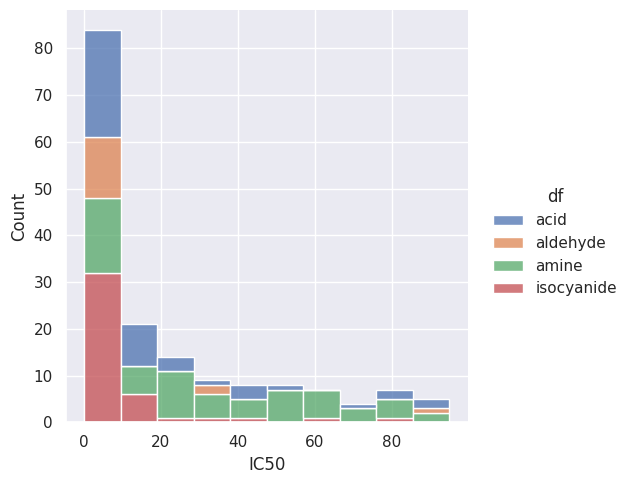

In [8]:
sns.set(rc={"figure.dpi":100})

names = ['acid', 'aldehyde', 'amine', 'isocyanide']
for i,df in enumerate(dfs_taut):
    df['df'] = names[i]

df_all = pd.concat(dfs_taut)
df_all['IC50'] = df_all['IC50'].astype(float)
# sns.displot(data = df_all, x="IC50", hue="df", kind='kde', cut=0)
sns.displot(data = df_all, x="IC50", hue="df", multiple="stack", bins=10)
# plt.legend()
plt.show()

In [10]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, Kernel, NormalizedKernelMixin, Hyperparameter
# from scipy.spatial.distance import squareform
# import scipy

# def gradientless_opt(obj_func, initial_theta, bounds):
#     opt_res = scipy.optimize.minimize(
#         obj_func, initial_theta, method="Nelder-Mead",
#         bounds=bounds)

#     return opt_res.x, opt_res.fun

# class Tanimoto(Kernel):
    
#     def __init__(self, magnitude=1.0, mag_scale_bounds=(1e-5, 1e5)):
#         self.magnitude = magnitude
#         self.mag_scale_bounds = mag_scale_bounds

#     @property
#     def hyperparameter_length_scale(self):
#         return Hyperparameter(
#             "magnitude", "numeric", self.mag_scale_bounds)

#     def __call__(self, X, Y=None, eval_gradient=False):
#         if eval_gradient:
#             raise NotImplementedError(
#                     "Gradient Evaluation not implemented.")
#         if Y is None:
#             K = np.empty((len(X), len(X)))
#             for i in range(len(X)):
#                 for j in range(len(X)):
#                     K[i,j] = np.dot(X[i],X[j])/(np.dot(X[i],X[i]) + np.dot(X[j],X[j]) - np.dot(X[i],X[j]))
# #             K = squareform(K)
# #             np.fill_diagonal(K, 1)
#             return self.magnitude*K
#         else:
#             K = np.empty((len(X), len(Y)))
#             for i in range(len(X)):
#                 for j in range(len(Y)):
#                     K[i,j] = np.dot(X[i],Y[j])/(np.dot(X[i],X[i]) + np.dot(Y[j],Y[j]) - np.dot(X[i],Y[j]))
#             return self.magnitude*K       
        
#     def diag(self, X):
#         return np.mag*np.ones(X.shape[0])
    
#     def is_stationary():
#         return False
# # K = Tanimoto(magnitude=1.0)
# # gpr = GaussianProcessRegressor(kernel=K, random_state=0, eval_gradient=False,optimizer=gradientless_opt).fit(X_train_morgan, y_train)
# # print(K.get_params())
# # for hyperparameter in K.hyperparameters:
# #     print(hyperparameter)



# Model Comparison

## Useful functions

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

class UncertainRandomForestRegressor(RandomForestRegressor):
    """Adapted from scikit-optimize.
    https://github.com/scikit-optimize/scikit-optimize/blob/master/skopt/learning/forest.py
    """

    def __init__(self,
                 n_estimators='warn',
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0,
                 warm_start=False):
        super().__init__(
             n_estimators=n_estimators,
             criterion=criterion,
             max_depth=max_depth,
             min_samples_split=min_samples_split,
             min_samples_leaf=min_samples_leaf,
             min_weight_fraction_leaf=min_weight_fraction_leaf,
             max_features=max_features,
             max_leaf_nodes=max_leaf_nodes,
             min_impurity_decrease=min_impurity_decrease,
             min_impurity_split=min_impurity_split,
             bootstrap=bootstrap,
             oob_score=oob_score,
             n_jobs=n_jobs,
             random_state=random_state,
             verbose=verbose,
             warm_start=warm_start)

    # def get_params(self, deep=True):
    #     """This method overrides the one inherited from sklearn.base.BaseEstimator
    #     which when trying to inspect instances of this class would throw a
    #     RuntimeError complaining that "scikit-learn estimators should always specify
    #     their parameters in the signature of their __init__ (no varargs).
    #     Constructor (self, *args, **kwargs) doesn't  follow this convention.".
    #     sklearn enforces this to be able to read and set the parameter names
    #     in meta algorithms like pipeline and grid search which we don't need.
    #     """
    #     return self.params

    def predict(self, X_test, no_var=True, get_aleat=False, aleat_only=False):
        """Predict continuous labels y_pred and uncertainty y_var
        (unless no_var=True) for X_test.
​
        Args:
            X_test (array-like, shape=(n_samples, n_features)): Input data.
            no_var=False (bool, optional): Don't return y_var if set to true.
​
        Returns:
            2- or 1-tuple: y_pred (and y_var)
        """
        if self.criterion != "mse":
            err = f"Expected impurity to be 'mse', instead got {self.criterion}."
            raise ValueError(err)
            
        y_pred = super().predict(X_test)
        if no_var:
            return y_pred
        if aleat_only:
            y_var_aleat = self.get_var(X_test, y_pred, aleat_only)
            return y_pred, y_var_aleat
        y_var, y_var_aleat = self.get_var(X_test, y_pred, aleat_only)
        if get_aleat:
            return y_pred, y_var, y_var_aleat
        return y_pred, y_var

    def get_var(self, X_test, y_pred, aleat_only=False):
        """Computes var(Y|X_test) via law of total variance E[Var(Y|Tree)] + Var(E[Y|Tree]).
        Note: Another option for estimating confidence intervals is be prediction
        variability, i.e. how influential training set is for producing observed
        random forest predictions. Implemented in
        https://github.com/scikit-learn-contrib/forest-confidence-interval.
        However, empirically our method of obtaining y_var seems to be more accurate.
​
        Args:
            X_test (array-like, shape=(n_samples, n_features)): Input data.
            y_pred (array-like, shape=(n_samples,)): Prediction for each sample
                as returned by RFR.predict(X_test).
​
        Returns:
            array-like, shape=(n_samples,): Standard deviation of y_pred at X_test.
            Since self.criterion is set to "mse", var[i] ~= var(y | X_test[i]).
        """
        # trees is a list of fitted binary decision trees.
        y_var, y_var_aleat, trees = *np.zeros([2, len(X_test)]), self.estimators_

        # Compute var(y|X_test) as described in sec. 4.3.2
        # of http://arxiv.org/pdf/1211.0906v2.pdf.
        for tree in trees:
            # Tree impurity modelling aleatoric uncertainty.
            var_tree = tree.tree_.impurity[tree.apply(X_test)]
            y_pred_tree = tree.predict(X_test)
            y_var += var_tree + y_pred_tree ** 2
            y_var_aleat += var_tree

        y_var /= len(trees)
        y_var_aleat /= len(trees)
        y_var -= y_pred ** 2
        if aleat_only:
            return y_var_aleat
        return y_var, y_var_aleat

    def get_corr(self, X_test, with_cov=False, alpha=1e-14):
        """Compute the Pearson correlation coefficient matrix of predictions. Each
        entry in the correlation matrix is the covariance between those random variables
        normalized by division with their respective standard deviations. See
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html.
        Args:
            X_test (array, shape=(n_samples, n_features)): Input data.

        Returns:
            array, shape=(n_samples, n_samples): Correlation coefficients between
            samples in X_test.
        """
        # Each row in preds represents a variable, in this case different samples
        # in X_test, while the columns contain a series of observations corresponding
        # to predictions from different trees in the forest.
        preds = np.array([tree.predict(X_test) for tree in self.estimators_]).T

        # Ensure the correlation matrix is positive definite despite rounding errors.
        psd = np.eye(len(X_test)) * alpha

        if with_cov:
            return np.corrcoef(preds) + psd, np.cov(preds) + psd
        return np.corrcoef(preds) + psd

In [37]:
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Kernel, RationalQuadratic, DotProduct, NormalizedKernelMixin, Hyperparameter, Matern


from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

def enrichment(y_true, y_pred, n=100, threshold=6, log=False):
    
    y_true = np.where(y_true>threshold, 1, 0) # replace pIC50s with binary labels
    orig_prop = np.sum(y_true)/len(y_true)
    best_n_inds = np.argsort(y_pred)[-n:][::-1]
    sorted_preds = y_true[best_n_inds] # pick predicted best n
    new_prop = np.sum(sorted_preds)/len(sorted_preds)
    if log:
        print('orig proportion of actives: {:.3f}%'.format(orig_prop*100))
        print('new proportion of actives: {:.3f}%'.format(new_prop*100))
    EF = new_prop/orig_prop

    return EF

def fit_forest(X,y, uncertain=False):
    if uncertain:
        model = UncertainRandomForestRegressor()
    else:
        model = RandomForestRegressor()

    # params = {'n_estimators': [100, 1000, 10000], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 4]}
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 50)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
    # max_depth = [int(x) for x in np.linspace(1, 110, num = 10)]
    # max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 4, 6, 8, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3, 4, 5]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    # params = {'n_estimators': [1000], 'max_depth': [1, 2]}
    search = RandomizedSearchCV(model, params, n_iter=100, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    model  = search.fit(X, y).best_estimator_
    print(search.best_params_)
    return model

def fit_gp(X,y):
    #  ARD: 0.1*np.ones(X[0].shape[1])

    # cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=None)

    # define grid
    nu_list = [0.5, 1.5, 2.5]

    kernel_list = []
    for nu in nu_list:
        kernel_list.append(1*Matern(0.1, nu=nu))
        kernel_list.append(1*Matern(0.1*np.ones(len(X[0])), nu=nu))

    kernel_list.append(1*RBF(0.1))
    kernel_list.append(1*RBF(0.1*np.ones(len(X[0]))))
    # grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1 *
    #                 RationalQuadratic(), 1*WhiteKernel()]

    params = {'kernel': kernel_list}
    # define search
    search = GridSearchCV(GaussianProcessRegressor(alpha=1e-6,
        normalize_y=True), params, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
    # perform the search
    results = search.fit(X, y)
    # print('Best params_: {}'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    # for mean, param in zip(means, params):
    #     print("R2>%.3f with: %r" % (mean, param))
    return results.best_estimator_   

def calc_metrics(model, model_name, X_train, y_train, X_test, y_test, test_inds):
    train_preds = model.predict(X_train)

    r2_train = r2_score(y_train,train_preds)
    rho_train = spearmanr(y_train, train_preds)[0]
    rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
    
    test_preds = model.predict(X_test)

    r2_test = r2_score(y_test[test_inds], test_preds[test_inds])
    rho_test = spearmanr(y_test[test_inds], test_preds[test_inds])[0]
    rmse_test = np.sqrt(mean_squared_error(y_test[test_inds], test_preds[test_inds]))

    df_train = pd.DataFrame({'model': model_name,
                             'R2': r2_train,
                             'rho': rho_train,
                             'RMSE': rmse_train},
                             index=[0])
    df_test = pd.DataFrame({'model': model_name,
                             'R2': r2_test,
                             'rho': rho_test,
                            'RMSE': rmse_test},
                             index=[0])
                             
    return test_preds, df_train, df_test

def plot_comparison(y_test, test_inds, pred_list, model_names,  title, threshold=6):
    # Enrichment
    y_true = np.where(y_test>threshold, 1, 0) # replace pIC50s with binary labels

    orig_prop = np.sum(y_true)/len(y_true)
    n_list = np.logspace(start=np.log10(5), stop=min(2,np.log10(len(y_test))), num=20) # only check top 100

    EFs = []
    for preds in pred_list:
        EFs.append([enrichment(y_test, preds, n=int(n), threshold=threshold) for n in n_list]) 

    n = len(pred_list)
    if n == 2:
        color_list = ['#ef5675', '#003f5c']
        alpha_list = [0.6, 0.7]
        lw_list = [1.5, 1]
    if n == 3:
        color_list = ['#ef5675', '#7a5195', '#ffa600']
        alpha_list = [0.6, 0.7, 0.8]

        lw_list = [2, 1.5, 1]

    if n == 4:
        color_list = ['#ef5675', '#003f5c', '#7a5195', '#ffa600']
        alpha_list = [0.6, 0.7, 0.8, 0.9]
        marker_list = ['o', 'x', 's', '+']
        lw_list = [2.5, 2, 1.5, 1]

    with plt.style.context('seaborn-white'):
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, constrained_layout=True)
        axs[0].plot([np.amin(y_test), np.amax(y_test)], [np.amin(y_test), np.amax(y_test)], 'k:', lw=1)

        for n, preds in enumerate(pred_list):
            axs[0].scatter(y_test[test_inds], preds[test_inds], alpha=alpha_list[n], label=model_names[n], c=color_list[n], s=4, marker=marker_list[n], edgecolors='none')
            axs[1].plot(n_list, EFs[n], '-', alpha=alpha_list[n], label=model_names[n], color=color_list[n], lw=lw_list[n])
            
        axs[0].set_title('pIC50 Regression')
        axs[0].set_xlabel('Measured pIC50')
        axs[0].set_ylabel('Predicted pIC50\n(n={})'.format(len(y_test[test_inds])))

        axs[1].plot(n_list, np.ones_like(n_list), 'k:')
        axs[1].set_yticks(list(plt.yticks()[0]) + [1])
        axs[1].set_ylim(bottom=0)        
        axs[1].legend(prop={'size': 8}, facecolor='white', framealpha=1, frameon=True, loc='upper right')
        axs[1].set_title('Enrichment (pIC50 > {})\n(including inactives)'.format(threshold))  
        axs[1].set_xlabel('n')
        axs[1].set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    plt.suptitle(title)
    plt.show() 


## Run and Plot Model Comparison

{'n_estimators': 1485, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
{'n_estimators': 714, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}
{'n_estimators': 1265, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Training Set
                model        R2       rho      RMSE
     Canon MPNN FP RF  0.949401  0.932297  0.174408
     Canon MPNN FP GP  0.973241  0.950740  0.126832
 Old Enum. MPNN FP RF  0.908125  0.912736  0.235015
            Morgan RF  0.911462  0.926261  0.230707

Test Set
                model        R2       rho      RMSE
     Canon MPNN FP RF  0.475924  0.636608  0.585322
     Canon MPNN FP GP  0.516760  0.625743  0.562055
 Old Enum. MPNN FP RF  0.161426  0.659542  0.740403
            Morgan RF -0.573090  0.378576  1.014085


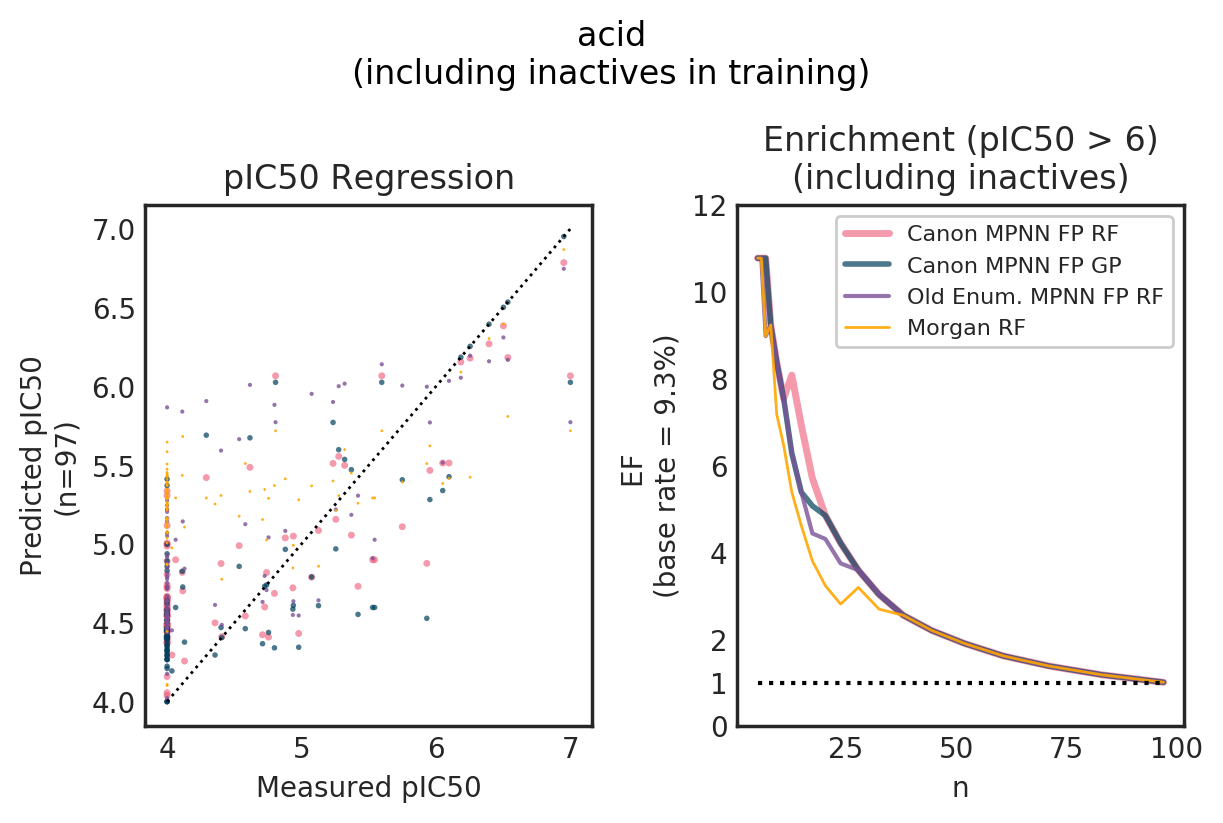

{'n_estimators': 1118, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
{'n_estimators': 1889, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}


In [38]:
model_names_2 = ['Canon MPNN FP RF', 'Canon MPNN FP GP']
model_names_3 = ['Canon MPNN FP RF', 'Old Enum. MPNN FP RF', 'Morgan RF']
model_names_4 = ['Canon MPNN FP RF', 'Canon MPNN FP GP', 'Old Enum. MPNN FP RF', 'Morgan RF']
split_names = ['acid', 'aldehyde', 'amines', 'isocyanide']
split_names_active = [x + '\n(only actives)' for x in split_names]
split_names_inactive = [x + '\n(including inactives in training)' for x in split_names]
threshold = 6 # pIC50 threshold for EF calculation

model_names = model_names_4

split_names = split_names_inactive
inactive = True

# test on inactives too!
test_inds_list = []
for x in xs_morgan_train:
    test_inds_list.append(range(len(x)))

# inactive = False
# split_names = split_names_active

for i, y_test in enumerate(ys):
    if not inactive:
        X_train_fps_old = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_old_train) if i!=j])
        X_train_fps_taut = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_taut_train) if i!=j])
        X_train_morgan_np = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_morgan_train) if i!=j])
        y_train = np.concatenate([y[test_inds_list[j]] for j,y in enumerate(ys) if i!=j])

    else:
        X_train_fps_old = np.concatenate([x for j,x in enumerate(xs_old_train) if i!=j])
        X_train_fps_taut = np.concatenate([x for j,x in enumerate(xs_taut_train) if i!=j])
        X_train_morgan_np = np.concatenate([x for j,x in enumerate(xs_morgan_train) if i!=j])
        y_train = np.concatenate([y for j,y in enumerate(ys) if i!=j])
        
    X_train = [X_train_fps_taut, X_train_fps_taut, X_train_fps_old, X_train_morgan_np]

    X_test_fps_old = xs_old_train[i]
    X_test_fps_taut = xs_taut_train[i]
    X_test_morgan_np = xs_morgan_train[i]
    X_test = [X_test_fps_taut, X_test_fps_taut, X_test_fps_old, X_test_morgan_np]

    rf_fps_old= fit_forest(X_train_fps_old, y_train.flatten(), uncertain=True)
    rf_fps_taut = fit_forest(X_train_fps_taut, y_train.flatten(), uncertain=True)
    rf_morgan = fit_forest(X_train_morgan_np, y_train.flatten(), uncertain = True)
    # gpr_taut = fit_gp(X_train_fps_taut, y_train.flatten())
    
    gpr_taut = GaussianProcessRegressor(alpha=1e-6, kernel=Matern(0.1, nu=0.5), normalize_y=True).fit(
        X_train_fps_taut, y_train.flatten())

    models = {'Canon MPNN FP RF': rf_fps_taut, 
              'Canon MPNN FP GP': gpr_taut, 
              'Old Enum. MPNN FP RF': rf_fps_old, 
              'Morgan RF': rf_morgan}

    models = [models[name] for name in model_names]

    pred_list = []
    train_dfs = []
    test_dfs = []
    for n, model in enumerate(models):
            test_pred, train_metrics, test_metrics = calc_metrics(model, model_names[n], # TODO indexing clash with dictionary
                                                                  X_train[n], y_train, 
                                                                  X_test[n], y_test, test_inds_list[i])
            pred_list.append(test_pred)
            train_dfs.append(train_metrics)
            test_dfs.append(test_metrics)

    df_train = pd.concat(train_dfs)
    print('Training Set')
    print(df_train.to_string(index=False))

    df_test = pd.concat(test_dfs)
    print('\nTest Set')
    print(df_test.to_string(index=False))
     
    plot_comparison(y_test, test_inds_list[i], pred_list, model_names, title=split_names[i])
    # compare_models(X_train_fps_old, X_train_fps_taut, X_train_morgan_np, y_train,
                #    X_test_fps_old, X_test_fps_taut, X_test_morgan_np,  y_test,
                #    title=split_names[i], threshold=threshold)

# old_train, old_test = train_test_split(np.concatenate(xs_old), random_state=42)
# taut_train, taut_test = train_test_split(np.concatenate(xs_taut), random_state=42)

# xs_morgan_fp = [fp_to_numpy(x) for fp in xs_morgan for x in fp ]
# x_morgan_train, x_morgan_test = train_test_split(xs_morgan_fp, random_state=42)

# y_train, y_test = train_test_split(np.concatenate(ys), random_state=42)

# compare_models(old_train, taut_train, x_morgan_train, y_train,
#               old_test, taut_test, x_morgan_test,  y_test,
#               title='random_all', threshold=threshold)


## Calibrating Uncertainties

{'n_estimators': 1779, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
{'n_estimators': 310, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}


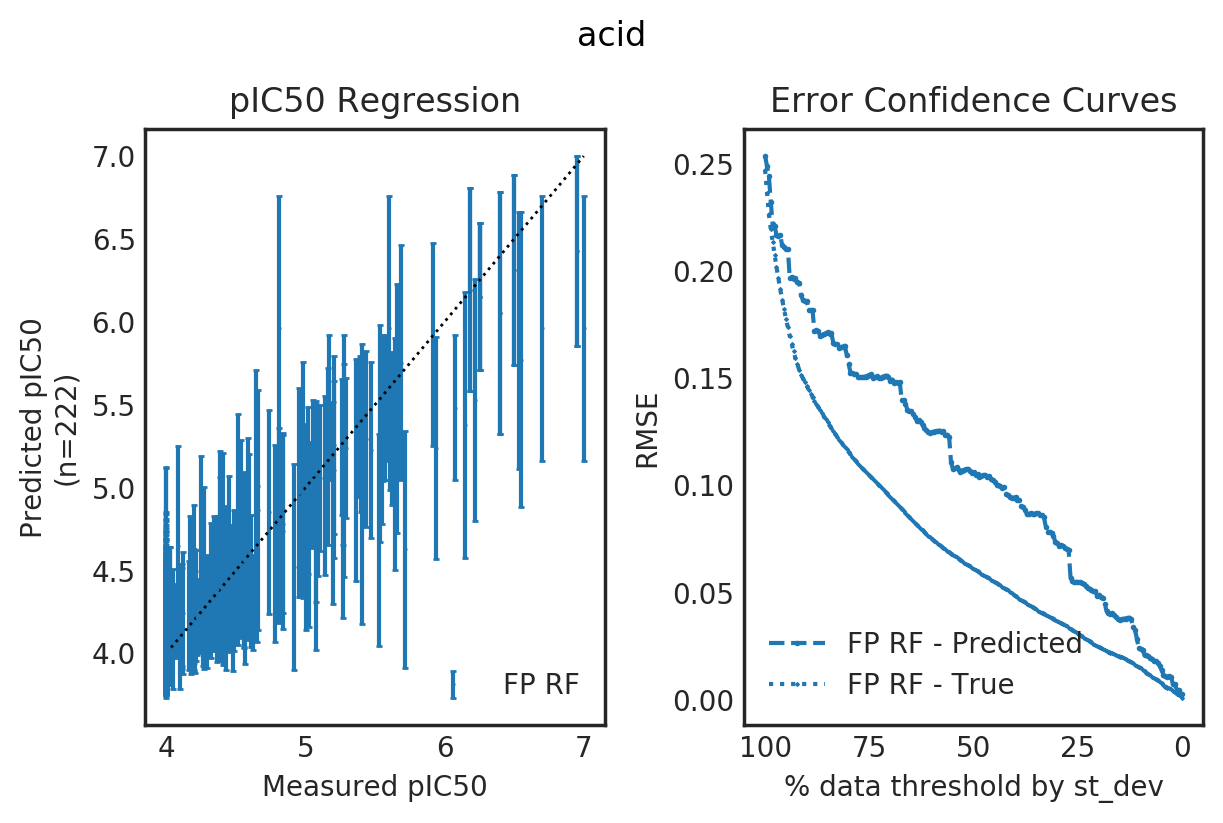

{'n_estimators': 1963, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}
{'n_estimators': 420, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


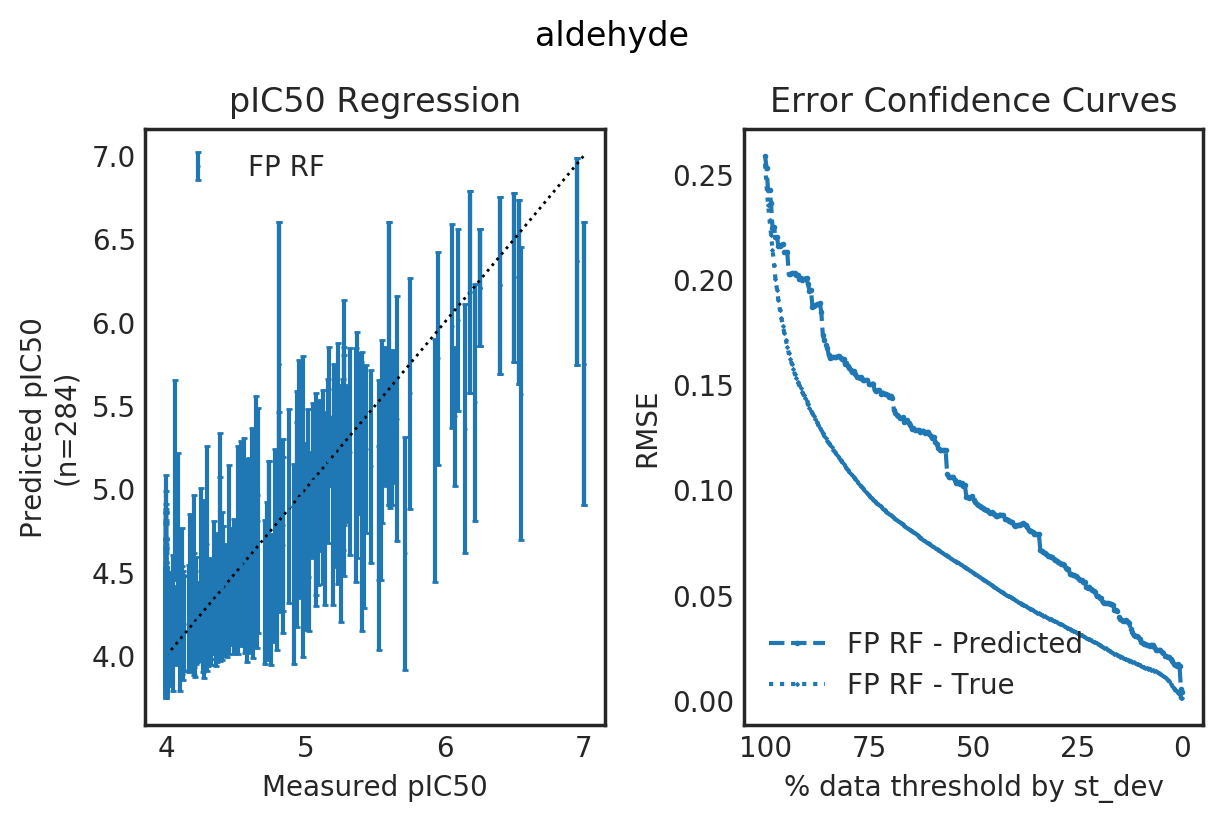

{'n_estimators': 1044, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
{'n_estimators': 751, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}


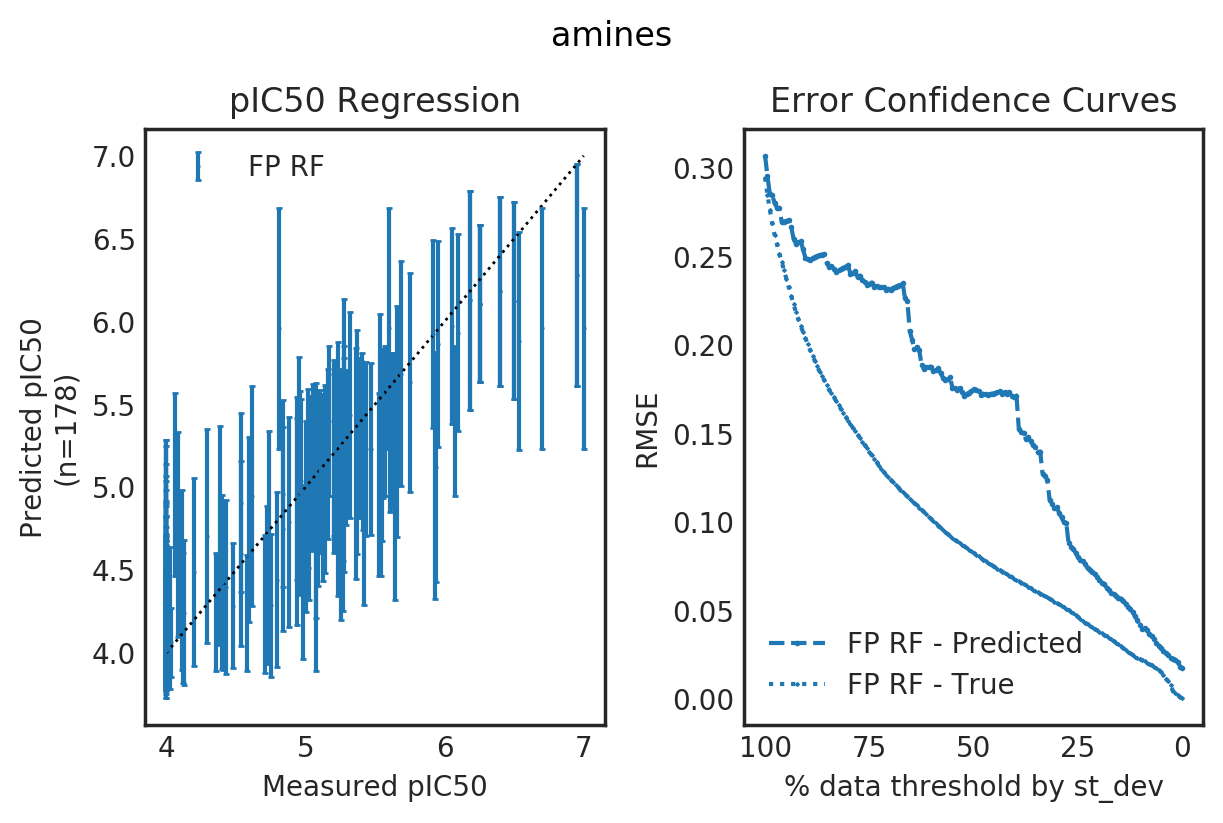

{'n_estimators': 310, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': False}
{'n_estimators': 310, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}


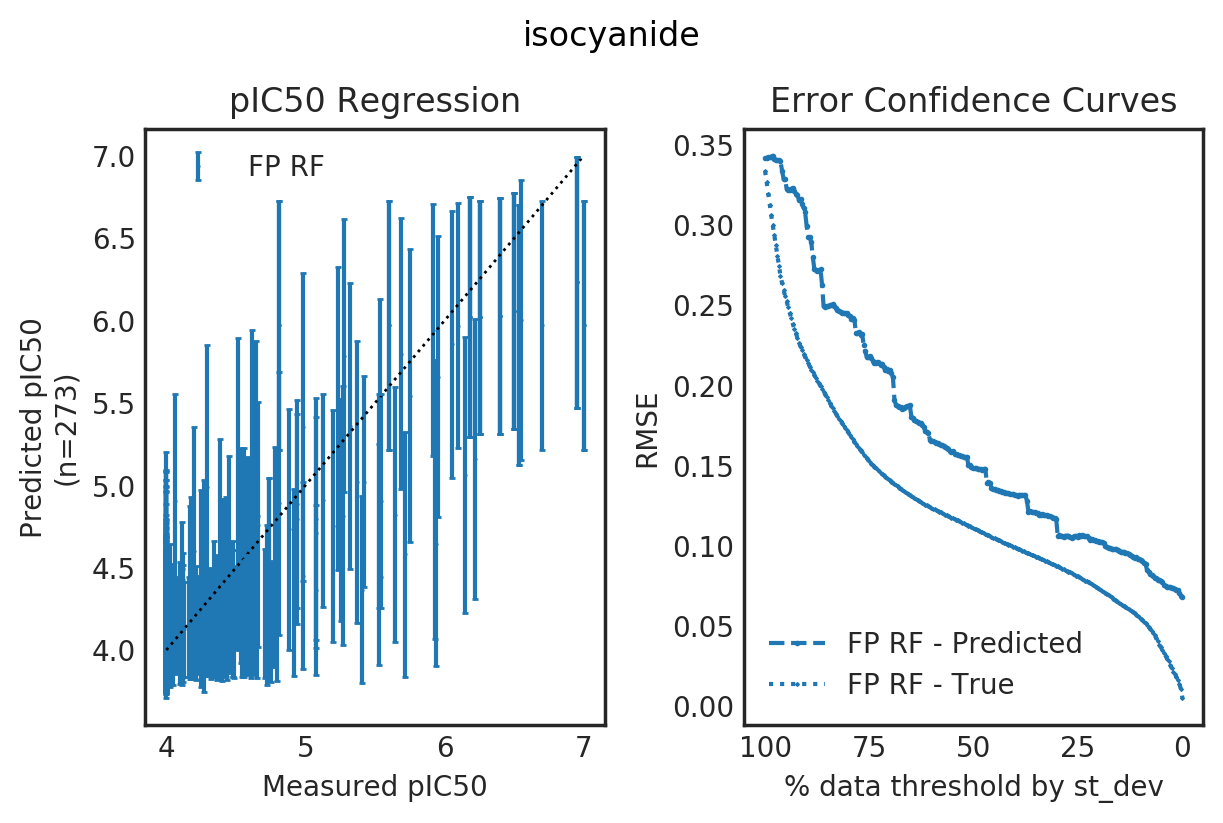

In [35]:
inactive = True
split_names = ['acid', 'aldehyde', 'amines', 'isocyanide']

def error_curve(y_test, y_pred, y_var, ax, name):
    n = len(y_test)-1

    errors = np.absolute(y_test-y_pred)

    RMSE_pred = np.zeros(n)
    RMSE_true = np.zeros(n)
    var_val = np.linspace(100, 0, n)
    x_max = np.sqrt(np.amax(y_var))
    x_min = np.sqrt(np.amin(y_var))
    y_pred_pred = y_pred
    y_pred_true = y_pred
    y_test_pred = y_test
    y_test_true = y_test
    for i in range(n):
            max_ind_pred = y_var.argmax()
            y_test_pred = np.delete(y_test_pred, max_ind_pred)
            y_pred_pred = np.delete(y_pred_pred, max_ind_pred, 0)
            RMSE_pred[i] = np.sqrt(mean_squared_error(y_test_pred, y_pred_pred))
            y_var = np.delete(y_var, max_ind_pred)

            max_ind_true = errors.argmax()
            y_test_true = np.delete(y_test_true, max_ind_true)
            y_pred_true = np.delete(y_pred_true, max_ind_true, 0)
            RMSE_true[i] = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
            errors = np.delete(errors, max_ind_true)

    num_dec = 0
    for i in range(len(RMSE_pred)):
    	if i != len(RMSE_pred)-1:
            if RMSE_pred[i] >= RMSE_pred[i+1]:
                num_dec += 1

    auco = np.sum(RMSE_pred-RMSE_true)
    errdrop = RMSE_pred[0]/RMSE_pred[-1]
    decrat = num_dec/len(RMSE_pred)

    color=next(ax._get_lines.prop_cycler)['color']

    ax.plot(var_val, RMSE_pred, linestyle='--', marker='o', color=color,
            markersize=1, label=name + ' - Predicted')
    ax.plot(var_val, RMSE_true, linestyle='dotted', marker='x', color=color,
            markersize=1, label=name + ' - True')
    ax.legend(loc='lower left')
    ax.set_xlabel('% data threshold by st_dev')
    ax.set_ylabel('RMSE')
    ax.set_title('Error Confidence Curves')
    return


for i, y_test in enumerate(ys):
    if not inactive:
        X_train_fps_taut = np.concatenate(
            [x[test_inds_list[j]] for j, x in enumerate(xs_taut_train) if i != j])
        X_train_morgan_np = np.concatenate(
            [x[test_inds_list[j]] for j, x in enumerate(xs_morgan_train) if i != j])
        y_train = np.concatenate([y[test_inds_list[j]]
                                 for j, y in enumerate(ys) if i != j])

    else:
        X_train_fps_taut = np.concatenate(
            [x for j, x in enumerate(xs_taut_train) if i != j])
        X_train_morgan_np = np.concatenate(
            [x for j, x in enumerate(xs_morgan_train) if i != j])
        y_train = np.concatenate([y for j, y in enumerate(ys) if i != j])

    X_train = [X_train_fps_taut, X_train_morgan_np]

    X_test_fps_taut = xs_taut_train[i]
    X_test_morgan_np = xs_morgan_train[i]
    # X_test = [X_test_fps_taut, X_test_morgan_np]
    X_test = [X_train_fps_taut, X_train_morgan_np]
    y_test = y_train

    rf_fps_taut = fit_forest(
        X_train_fps_taut, y_train.flatten(), uncertain=True)
    rf_morgan = fit_forest(
        X_train_morgan_np, y_train.flatten(), uncertain=True)

    preds_fps, var_fps = rf_fps_taut.predict(X_test_fps_taut, no_var=False)
    preds_fps, var_fps = rf_fps_taut.predict(X_train_fps_taut, no_var=False)
    # preds_morgan, var_morgan = rf_morgan.predict(
    #     X_test_morgan_np, no_var=False)

    # pred_list = [preds_fps, preds_morgan]
    # var_list = [var_fps, var_morgan]
    # model_names = ['FP RF', 'Morgan RF']
    pred_list = [preds_fps]
    var_list = [var_fps]
    model_names = ['FP RF']
    with plt.style.context('seaborn-white'):
        fig, axs = plt.subplots(
            nrows=1, ncols=2, dpi=200, constrained_layout=True)
        axs[0].plot([np.amin(y_test), np.amax(y_test)], [
                    np.amin(y_test), np.amax(y_test)], 'k:', lw=1)

        for n, preds in enumerate(pred_list):
            # axs[0].plot(preds, np.sqrt(var_list[n]), label=model_names[n], marker='.', linestyle='')
            # print(np.sqrt(var_list[n], axis=0).shape)
            axs[0].errorbar(y_test, preds, label=model_names[n], yerr=np.sqrt(var_list[n]), linestyle='', marker='.', markersize=1, capsize=1)
            error_curve(y_test, preds, var_list[n], ax=axs[1], name=model_names[n]) 
        axs[1].invert_xaxis()
        axs[0].set_title('pIC50 Regression')
        axs[0].set_xlabel('Measured pIC50')
        axs[0].set_ylabel(
            'Predicted pIC50\n(n={})'.format(len(y_test)))
        axs[0].legend()
    plt.suptitle(split_names[i])
    plt.show()  


# Running predictions on new datasets

In [6]:
print('Fitting RF models')
rf_taut = fit_forest(np.concatenate(xs_taut), np.concatenate(ys).flatten())
rf_old = fit_forest(np.concatenate(xs_old), np.concatenate(ys).flatten())

old_model='/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
taut_model='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

def run_prediction(path, model, load_name, savename=None, canon=False):

    df_score = pd.read_csv(path, usecols=['SMILES'])
    if canon:
        df_score['SMILES'] = canon_tautomers(df_score['SMILES']) # already done so just save some time lmao

    x_new = gen_fps(df_score, load_name=load_name)

    preds = model.predict(x_new)

    df_score['predicted_pIC50'] = preds
    # df_score = df_score.sort_values(by='predicted_pIC50', ascending=False)

    if savename:
        df_score.to_csv(savename, index=False)
    return df_score

# print('Running Tautomer predictions...')
# df_p4 = run_prediction('../to_score/p4_picks.csv', model=rf_taut, load_name=taut_model, canon=True)
# df_p41 = run_prediction('../to_score/p4_picks1.csv', model=rf_taut, load_name=taut_model, canon=True)
# df_amines = run_prediction('../to_score/amines_product_to_score.csv', model=rf_taut, load_name=taut_model, canon=True)

# df_p4['df'] = 'p4_picks'
# df_p41['df'] = 'p4_picks1'
# df_amines['df'] = 'amines_product'
# df_taut = pd.concat([df_p4, df_p41, df_amines])
# df_taut.to_csv('../to_score/df_taut.csv', index=False)

# print('Running old model predictions...')
# df_p4 = run_prediction('../to_score/p4_picks.csv', model=rf_old, load_name=old_model)
# df_p41 = run_prediction('../to_score/p4_picks1.csv', model=rf_old, load_name=old_model)
# df_amines = run_prediction('../to_score/amines_product_to_score.csv', model=rf_old, load_name=old_model)

# df_p4['df'] = 'p4_picks'
# df_p41['df'] = 'p4_picks1'
# df_amines['df'] = 'amines_product'

# df_old = pd.concat([df_p4, df_p41, df_amines])
# df_old.to_csv('../to_score/df_old.csv', index=False)


Fitting RF models


### Ensemble predictions

In [8]:
print('Fitting RF models')

n_models = 10

old_model='/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
taut_model='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

dfs_p4 = []
dfs_p41 = []
dfs_amines = []
for n in tqdm(range(n_models)):
    rf_taut = fit_forest(np.concatenate(xs_taut), np.concatenate(ys).flatten())
    dfs_p4.append(run_prediction('../to_score/p4_picks_scored_taut.csv', model=rf_taut, load_name=taut_model))
    dfs_p41.append(run_prediction('../to_score/p4_picks1_scored_taut.csv', model=rf_taut, load_name=taut_model))
    dfs_amines.append(run_prediction('../to_score/amines_product_scored_taut.csv', model=rf_taut, load_name=taut_model))

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting RF models
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 10%|█         | 1/10 [00:27<04:04, 27.17s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 20%|██        | 2/10 [00:49<03:15, 24.48s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 30%|███       | 3/10 [01:15<02:54, 24.93s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 40%|████      | 4/10 [01:41<02:33, 25.53s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 50%|█████     | 5/10 [02:09<02:11, 26.30s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 60%|██████    | 6/10 [02:34<01:44, 26.06s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 70%|███████   | 7/10 [03:00<01:17, 25.99s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 80%|████████  | 8/10 [03:26<00:51, 25.87s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 90%|█████████ | 9/10 [03:52<00:26, 26.09s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


100%|██████████| 10/10 [04:21<00:00, 26.20s/it]


In [ ]:
from functools import reduce

scores = []
for n in range(n_models):
    score_name = 'score_'+str(n)
    dfs_p4[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    dfs_p41[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    dfs_amines[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    scores.append(score_name)

def merge_ensemble(dfs):
    df_merged = pd.concat(dfs, axis=1)
    df_merged = df_merged.loc[:,~df_merged.columns.duplicated()]
    df_merged['pred_mean'] = np.mean(df_merged[scores], axis=1)
    df_merged['pred_std'] = np.std(df_merged[scores], axis=1)
    return df_merged[['SMILES', 'pred_mean', 'pred_std']].sort_values(by='pred_mean', ascending=False)

df_p4_merged = merge_ensemble(dfs_p4)
df_p41_merged = merge_ensemble(dfs_p41)
df_amine_merged = merge_ensemble(dfs_amines)

df_p4_merged.to_csv('../to_score/p4_picks_scored_ensemble.csv', index=False)
df_p41_merged.to_csv('../to_score/p4_picks1_scored_ensemble.csv', index=False)
df_amine_merged.to_csv('../to_score/amines_product_scored_ensemble.csv', index=False)

## Visualisation

Text(0.5, 0.98, 'Ugi pIC50 model comparison')

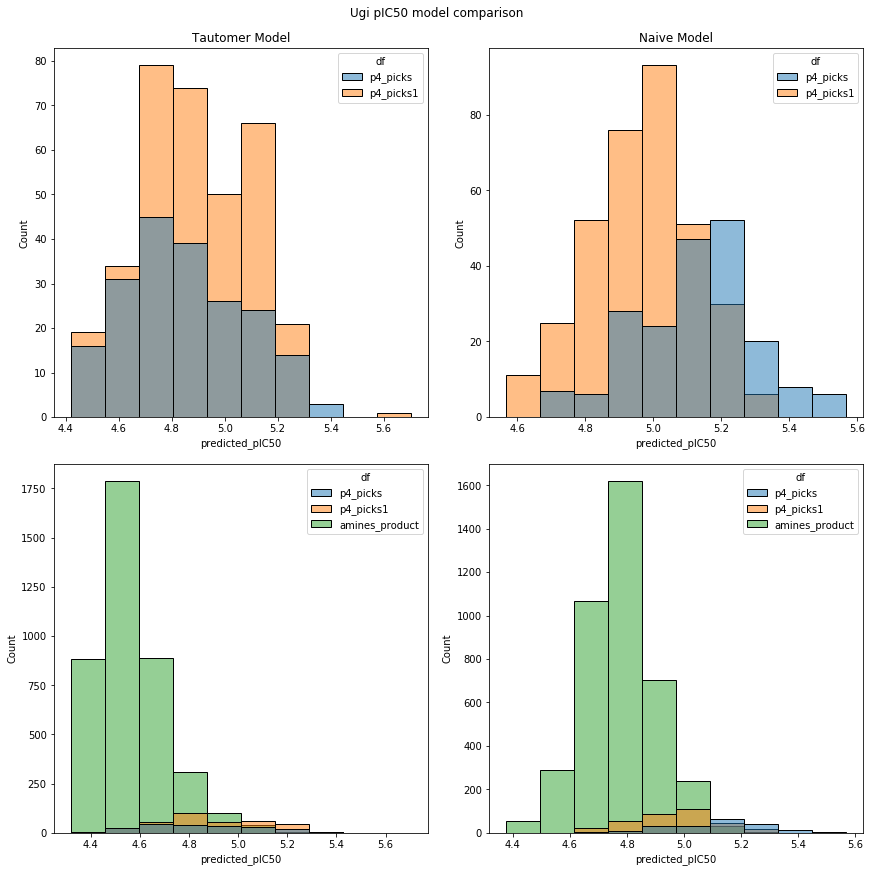

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12), constrained_layout=True)
sns.histplot(ax=axes[0,0], data = df_taut[df_taut['df']!='amines_product'], x="predicted_pIC50", hue="df", bins=10)
sns.histplot(ax=axes[0,1], data = df_old[df_old['df']!='amines_product'], x="predicted_pIC50", hue="df", bins=10)
axes[0,0].set_title('Tautomer Model')
axes[0,1].set_title('Naive Model')

sns.histplot(ax=axes[1,0], data = df_taut, x="predicted_pIC50", hue="df", bins=10)
sns.histplot(ax=axes[1,1], data = df_old, x="predicted_pIC50", hue="df", bins=10)
plt.suptitle('Ugi pIC50 model comparison')
# plt.title('pIC50 predicitions from tautomer model')

### Top-N amines from new model

In [8]:
import mols2grid
from rdkit.Chem import rdFMCS

df_taut = pd.read_csv('../to_score/df_taut.csv')
df_old = pd.read_csv('../to_score/df_old.csv')
df_amines = df_taut[df_taut['df']=='amines_product']
df_best = df_amines.nlargest(20, columns='predicted_pIC50')

mols = [MolFromSmiles(smi) for smi in df_best['SMILES']]
mcs=rdFMCS.FindMCS(mols)
mcs_query = Chem.MolFromSmarts(mcs.smartsString)            
AllChem.Compute2DCoords(mcs_query)
for m in mols: 
    AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
df_best['mols'] = mols

mols2grid.display(df_best,
                  mol_col='mols',
                  smiles_col='SMILES',
                  subset=['img','predicted_pIC50'],
                  transform={"predicted_pIC50": lambda x: f"y_pred: {x:.3f}"},
                  tooltip=["SMILES"],
                  useSVG=True,
                  use_coords=True,
                  selection=False,
                  n_rows=5,
                  size=(240,260),
                  width='85%')


### Mols with biggest difference

In [10]:
df_both = df_taut.merge(df_old, how='inner', left_index=True, right_index=True)
df_both = df_both[df_both['df_x']=='amines_product']
df_both = df_both.rename(columns={'predicted_pIC50_x': 'pred_new',
                                  'predicted_pIC50_y': 'pred_old'})
df_both['diff'] = df_both['pred_new'] - df_both['pred_old']
df_both['abs_diff'] = np.abs(df_both['diff'])

# df_diff = df_both
df_diff = df_both.nlargest(100, columns='diff')
df_diff = df_both.nsmallest(100, columns='diff')

mols = [MolFromSmiles(smi) for smi in df_diff['SMILES_x']]
mcs=rdFMCS.FindMCS(mols)
mcs_query = Chem.MolFromSmarts(mcs.smartsString)            
AllChem.Compute2DCoords(mcs_query)
for m in mols: 
    AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
df_diff['mols'] = mols

mols2grid.display(df_diff,
                  mol_col='mols',
                  smiles_col='SMILES_x',
                  subset=['img','diff'],
                  transform={"diff": lambda x: f"Δ y_pred: {x:.3f}"},
                  tooltip=["SMILES_x"],
                  useSVG=True,
                  use_coords=True,
                  selection=False,
                  n_rows=5,
                  size=(240,260),
                  width='85%')


In [7]:
# Alpha's test & searching for molecules

test_mols = [   'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC(C)C)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC5CCC5)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(C(C)(C)C)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(CC5COC5)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(C5COC5)cc4']
test_df = pd.DataFrame(test_mols, columns=['SMILES'])
print(test_df)

# search='CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1cscn1'
search = 'CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1c[nH]cn1'
# search = 'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC(C)C)cc4'
df_all = pd.concat(dfs_taut)
print(df_all[df_all['SMILES'].isin([search])])

                                              SMILES
0  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
1  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
2  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
3  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
4  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
